In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn import preprocessing

# Download NLTK stopwords
nltk.download('stopwords')


In [9]:
# Load the datasets
data = pd.read_csv("twitter_training.csv")
v_data = pd.read_csv("twitter_validation.csv")

# Assign proper column names
data.columns = ['id', 'game', 'sentiment', 'text']
v_data.columns = ['id', 'game', 'sentiment', 'text']


(74681, 4)
Index(['id', 'game', 'sentiment', 'text'], dtype='object')
                  id                  game sentiment   text
count   74681.000000                 74681     74681  73995
unique           NaN                    32         4  69490
top              NaN  TomClancysRainbowSix  Negative       
freq             NaN                  2400     22542    172
mean     6432.640149                   NaN       NaN    NaN
std      3740.423819                   NaN       NaN    NaN
min         1.000000                   NaN       NaN    NaN
25%      3195.000000                   NaN       NaN    NaN
50%      6422.000000                   NaN       NaN    NaN
75%      9601.000000                   NaN       NaN    NaN
max     13200.000000                   NaN       NaN    NaN


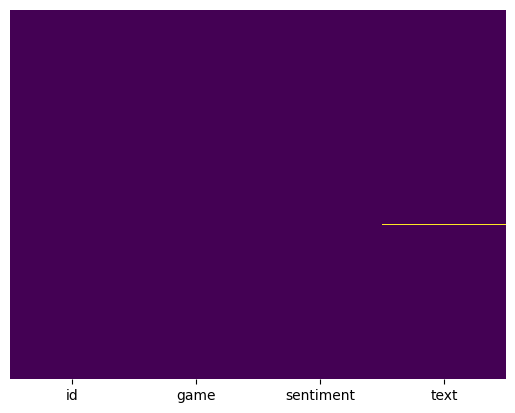

           Total Missing  In Percent
text                 686        0.92
id                     0        0.00
game                   0        0.00
sentiment              0        0.00


In [10]:
# Check the shape and structure of the dataset
print(data.shape)
print(data.columns)
print(data.describe(include='all'))

# Check for missing values
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

# Count the missing data in each column
total_null = data.isnull().sum().sort_values(ascending=False)
percent = ((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total_null, percent.round(2)], axis=1, keys=['Total Missing', 'In Percent'])
print(missing_data.head(10))


In [11]:
# Drop rows with missing text
data.dropna(subset=['text'], inplace=True)

# Check again for missing values
print(data.isnull().sum())


id           0
game         0
sentiment    0
text         0
dtype: int64


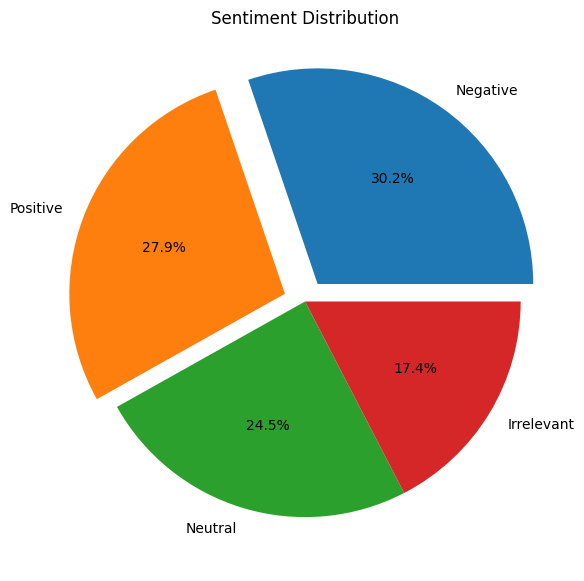

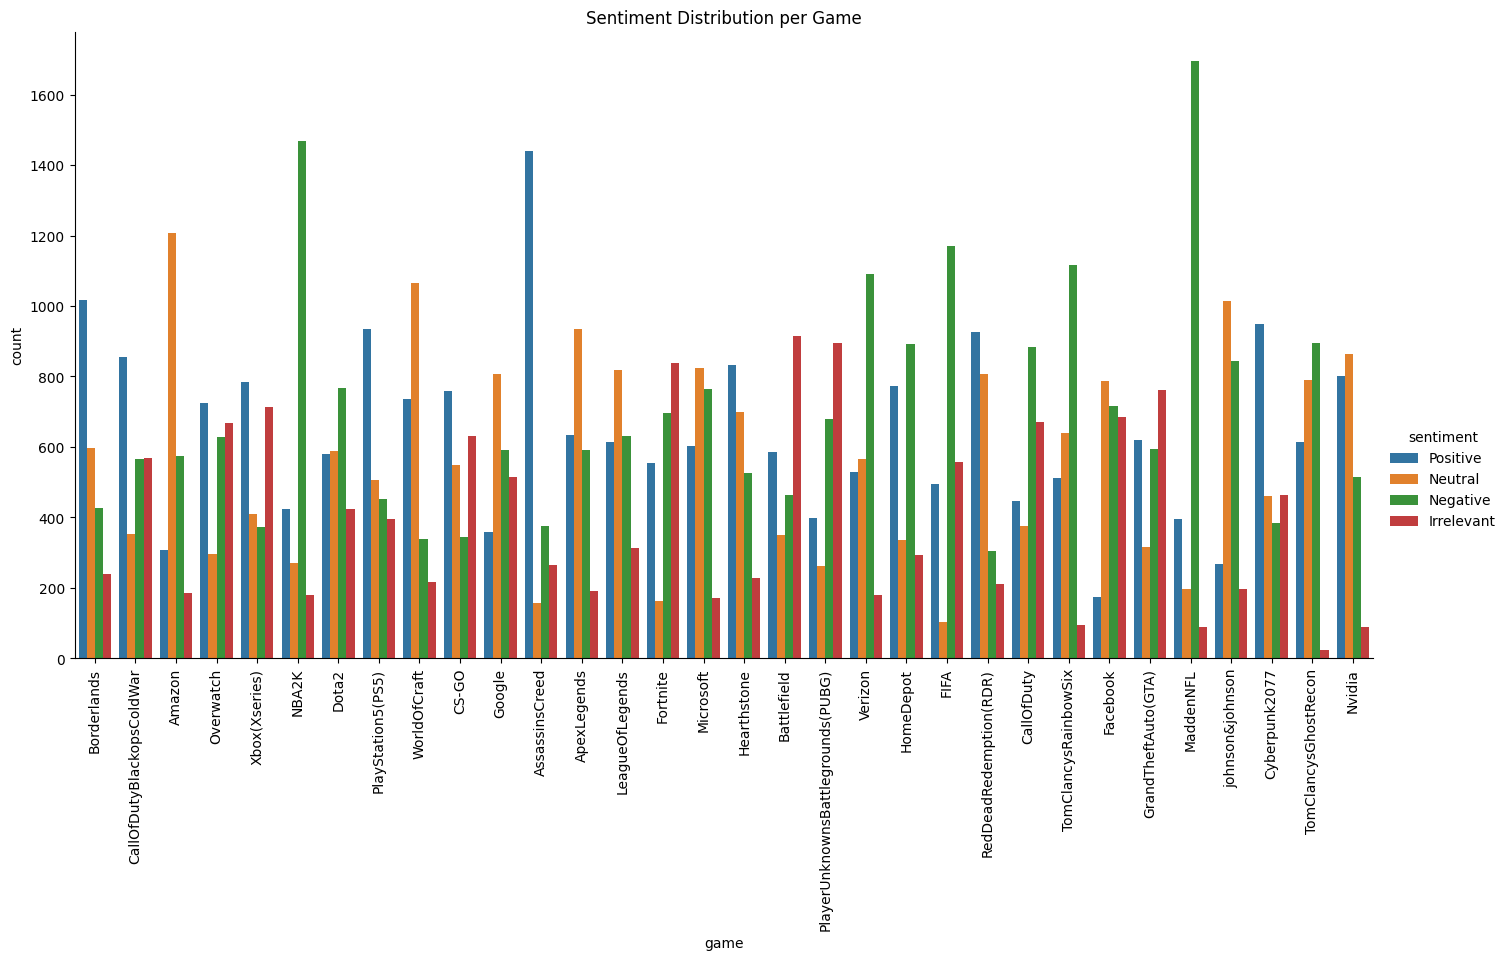

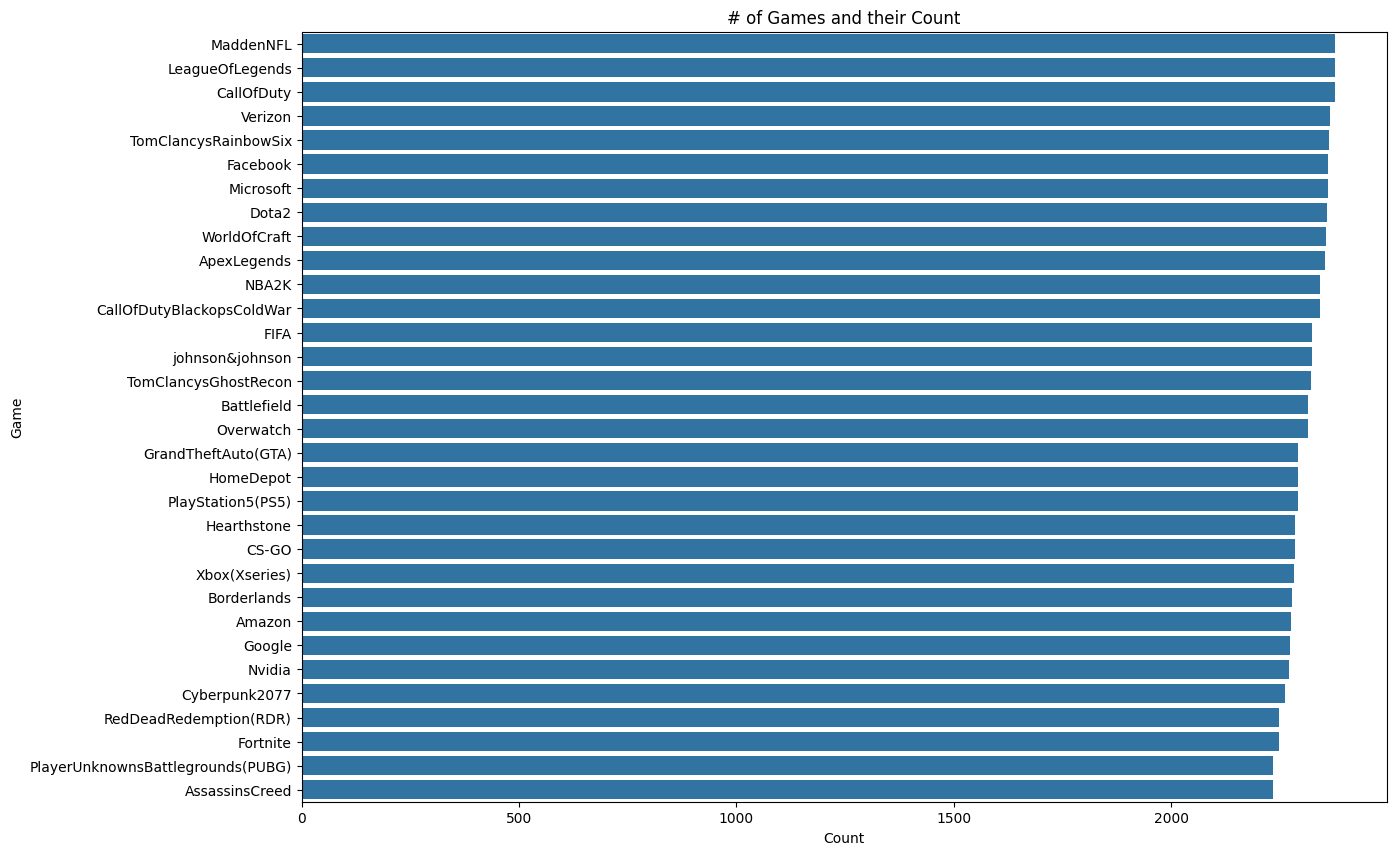

In [12]:
# Sentiment distribution
sentiment_types = data['sentiment'].value_counts()

plt.figure(figsize=(12,7))
plt.pie(x=sentiment_types.values, labels=sentiment_types.index, autopct='%.1f%%', explode=[0.1, 0.1, 0, 0])
plt.title('Sentiment Distribution')
plt.show()

# Count of sentiments per game
sns.catplot(x='game', hue='sentiment', kind='count', height=7, aspect=2, data=data)
plt.title('Sentiment Distribution per Game')
plt.xticks(rotation=90)
plt.show()

# Game frequency distribution
game_types = data['game'].value_counts()

plt.figure(figsize=(14,10))
sns.barplot(x=game_types.values, y=game_types.index)
plt.title('# of Games and their Count')
plt.ylabel('Game')
plt.xlabel('Count')
plt.show()


In [13]:
# Encode categorical data
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data['game'] = label_encoder.fit_transform(data['game'])
v_data['sentiment'] = label_encoder.fit_transform(v_data['sentiment'])
v_data['game'] = label_encoder.fit_transform(v_data['game'])

# Drop the 'id' column
data = data.drop(['id'], axis=1)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare the text data for model training
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(data['text'])
y_train = data['sentiment']

# Train a Naive Bayes classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# Prepare the validation data
X_val = tfidf.transform(v_data['text'])
y_val = v_data['sentiment']

# Predict on validation data
y_pred = model.predict(X_val)

# Evaluate the model
print("Accuracy: ", accuracy_score(y_val, y_pred))
print("Classification Report: \n", classification_report(y_val, y_pred))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred))


Accuracy:  0.7137137137137137
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.51      0.63       171
           1       0.66      0.83      0.74       266
           2       0.78      0.62      0.69       285
           3       0.68      0.82      0.75       277

    accuracy                           0.71       999
   macro avg       0.74      0.70      0.70       999
weighted avg       0.73      0.71      0.71       999

Confusion Matrix: 
 [[ 87  35  12  37]
 [  1 222  17  26]
 [ 12  54 177  42]
 [  5  23  22 227]]


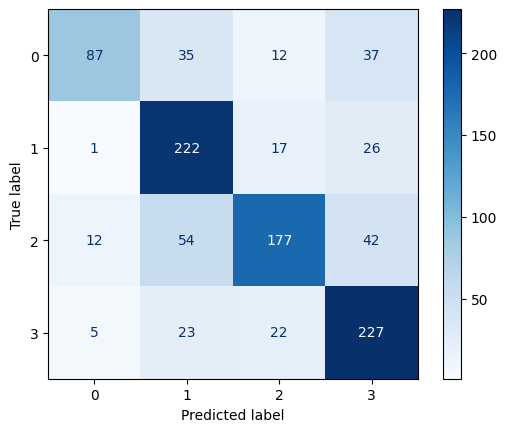

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, cmap='Blues')
plt.show()


Best Parameters:  {'alpha': 10}
Accuracy:  0.6206206206206206
Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.15      0.26       171
           1       0.56      0.85      0.68       266
           2       0.74      0.51      0.60       285
           3       0.60      0.81      0.69       277

    accuracy                           0.62       999
   macro avg       0.69      0.58      0.56       999
weighted avg       0.68      0.62      0.59       999

Confusion Matrix: 
 [[ 26  61  18  66]
 [  0 226  15  25]
 [  2  83 145  55]
 [  2  33  19 223]]


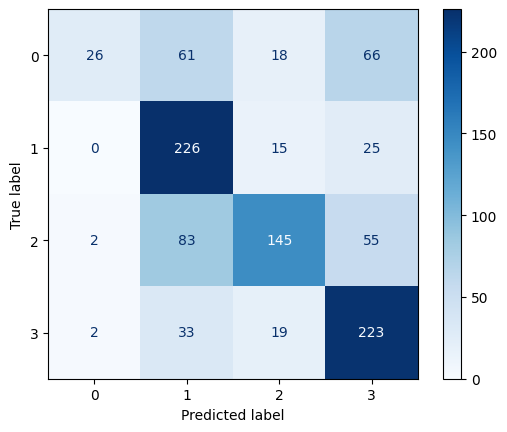

In [16]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [0.01, 0.1, 1, 10]
}

# Initialize GridSearchCV with the MultinomialNB model
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters: ", best_params)

# Evaluate the best model on the validation set
y_pred_best = best_model.predict(X_val)
print("Accuracy: ", accuracy_score(y_val, y_pred_best))
print("Classification Report: \n", classification_report(y_val, y_pred_best))
print("Confusion Matrix: \n", confusion_matrix(y_val, y_pred_best))

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_val, y_val, cmap='Blues')
plt.show()


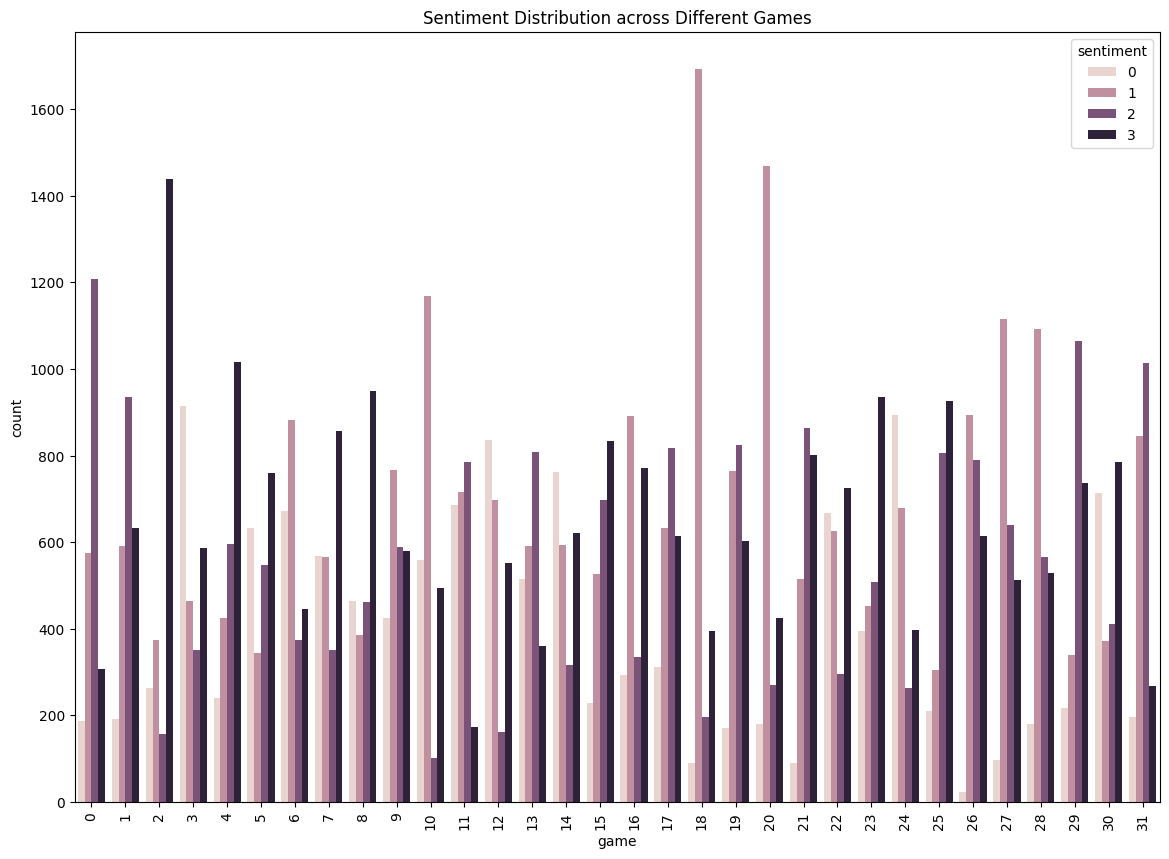

In [17]:
# Sentiment Distribution across Games
plt.figure(figsize=(14, 10))
sns.countplot(x='game', hue='sentiment', data=data)
plt.title('Sentiment Distribution across Different Games')
plt.xticks(rotation=90)
plt.show()


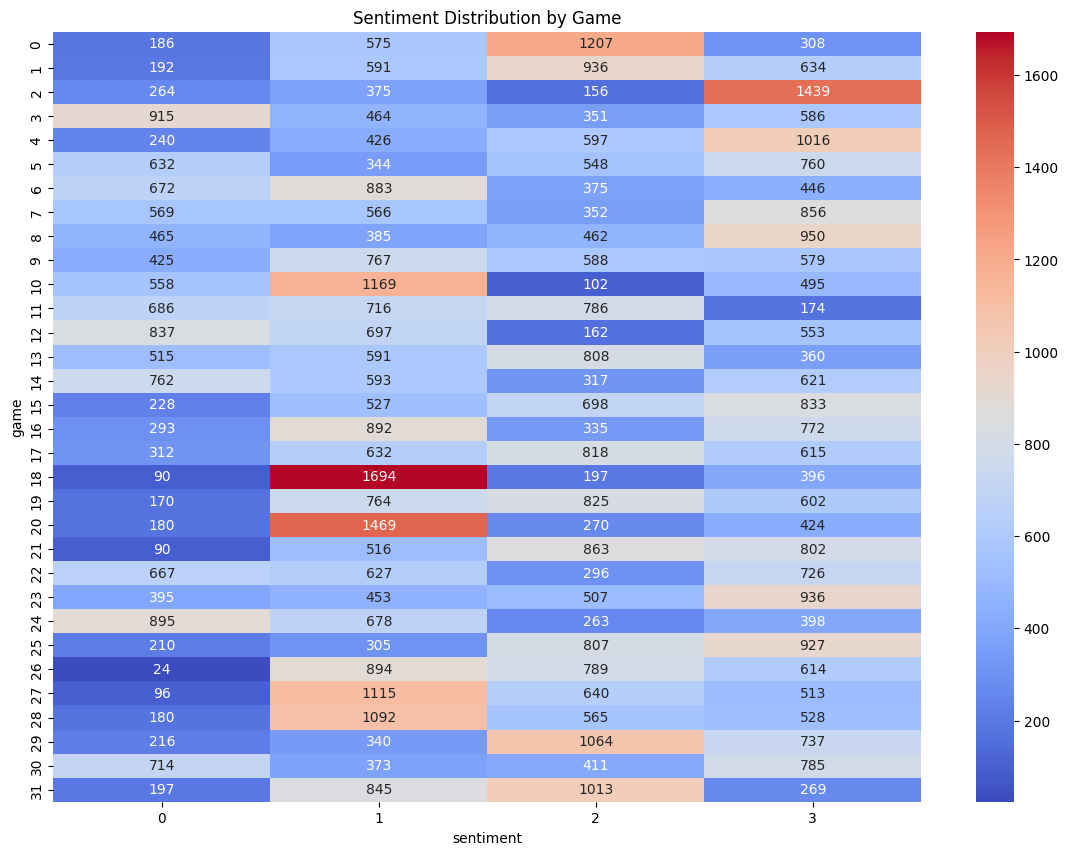

In [18]:
# Pivot the data to create a matrix for the heatmap
sentiment_game_pivot = pd.crosstab(data['game'], data['sentiment'])

# Plotting the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(sentiment_game_pivot, annot=True, cmap="coolwarm", fmt='d')
plt.title('Sentiment Distribution by Game')
plt.show()
